In [1]:
from keras.layers import Input, Dense, LSTM
from keras.models import Model, Sequential
import numpy as np
import glob
from tqdm import tqdm
import os
import manipulacion_midi
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
tiempos_previos=5                               #Numero de tiempos previos utilizados para el entrenamiento y la prediccion
longitud_minima=15                       #Tamaño minimo (en tiempos) que deben tener las canciones del conjunto de entrenamiento
carpeta_canciones='../canciones_entrenamiento'  #Carpeta donde estan las canciones el entrenamiento
modelo_guardado='mejor_modelo_lstm.hdf5'        #Nombre del archivo donde se guardara el modelo entrenado

#Elimina los tiempos vacios antes de todas las canciones
def eliminar_zeros_iniciales(arr):
    i=0
    ceros=np.zeros_like(arr[0])
    tamano=np.size(arr,0)
    while np.array_equal(arr[i],ceros) and tamano!=1:
        arr=np.delete(arr,i, axis=0)
        tamano=tamano-1
    return arr

def leer_canciones(ruta):
    print('Cargando archivos...')
    archivos = glob.glob('{}/*.mid*'.format(ruta))
    archivos = np.array(np.sort(archivos))
    archivos = archivos.tolist()
    global canciones
    global numero_cancion
    canciones = []
    numero_cancion=0
    for f in tqdm(archivos):
        print(f)
        try:
            cancion = np.array(manipulacion_midi.midiToNoteStateMatrix(f))			#Convierte los archivos .mid a matrices 
            cancion=eliminar_zeros_iniciales(cancion)
            tam = np.array(cancion).shape[0]
            print(tam)
            if tam > longitud_minima:
                if(numero_cancion==0):
                    canciones=cancion
                    numero_cancion=numero_cancion+1
                else:
                    canciones= np.concatenate([canciones, cancion], axis=0)
                    numero_cancion=numero_cancion+1
        except Exception as e:
            raise e
    return canciones

#Convierte el arreglo 2D de entradas en un arreglo 3D para entrenar el sistema
def dimensionar(w):
    for t, val in enumerate(w):
        u[0, t] = val
    return u

In [3]:
#Cargar canciones
canciones = leer_canciones(carpeta_canciones)

print("Se cargaron {} canciones".format(numero_cancion))

Cargando archivos...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

../canciones_entrenamiento\K19d Piano Sonata Duet.mid
1761


  3%|██▊                                                                                | 1/30 [00:00<00:20,  1.43it/s]

../canciones_entrenamiento\K279 Piano sonata n01 1mov.mid
2204


  7%|█████▌                                                                             | 2/30 [00:01<00:19,  1.45it/s]

../canciones_entrenamiento\K279 Piano sonata n01 3mov.mid
1708


 10%|████████▎                                                                          | 3/30 [00:01<00:18,  1.49it/s]

../canciones_entrenamiento\K281 Piano Sonata n03 1mov.mid
2516


 13%|███████████                                                                        | 4/30 [00:02<00:18,  1.44it/s]

../canciones_entrenamiento\K281 Piano Sonata n03 3mov.mid
2387


 17%|█████████████▊                                                                     | 5/30 [00:04<00:22,  1.13it/s]

../canciones_entrenamiento\K309 Piano Sonata n10 1mov.mid
4957


 20%|████████████████▌                                                                  | 6/30 [00:07<00:36,  1.52s/it]

../canciones_entrenamiento\K309 Piano Sonata n10 3mov.mid
2014


 23%|███████████████████▎                                                               | 7/30 [00:08<00:32,  1.43s/it]

../canciones_entrenamiento\K330 Piano Sonata n10 1mov.mid
2399


 27%|██████████████████████▏                                                            | 8/30 [00:09<00:32,  1.47s/it]

../canciones_entrenamiento\K330 Piano Sonata n10 3mov.mid
2731


 30%|████████████████████████▉                                                          | 9/30 [00:12<00:35,  1.70s/it]

../canciones_entrenamiento\K331 Piano sonata n11 3mov.mid
1785


 33%|███████████████████████████▎                                                      | 10/30 [00:12<00:27,  1.38s/it]

../canciones_entrenamiento\K333 Piano Sonata n13 1mov.mid
5281


 37%|██████████████████████████████                                                    | 11/30 [00:15<00:36,  1.93s/it]

../canciones_entrenamiento\K333 Piano Sonata n13 3mov.mid
3153


 40%|████████████████████████████████▊                                                 | 12/30 [00:17<00:35,  1.96s/it]

../canciones_entrenamiento\K358 Piano Sonata 4 Hands.mid
1777


 43%|███████████████████████████████████▌                                              | 13/30 [00:18<00:27,  1.60s/it]

../canciones_entrenamiento\K381 Piano Sonata 4 Hands.mid
1553


 47%|██████████████████████████████████████▎                                           | 14/30 [00:19<00:21,  1.37s/it]

../canciones_entrenamiento\K521 Piano Sonata 4 Hands.mid
3649


 50%|█████████████████████████████████████████                                         | 15/30 [00:21<00:21,  1.41s/it]

../canciones_entrenamiento\K545 Piano Sonata.mid
2369


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:21<00:17,  1.23s/it]

../canciones_entrenamiento\K570 Piano Sonata 2mov.mid
1265


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:22<00:13,  1.01s/it]

../canciones_entrenamiento\K570 Piano Sonata 3mov.mid
1939


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:22<00:10,  1.14it/s]

../canciones_entrenamiento\Piano Sonata n01 K279.mid
1617


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:24<00:10,  1.06it/s]

../canciones_entrenamiento\Piano Sonata n03 K281.mid
1745


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:25<00:10,  1.01s/it]

../canciones_entrenamiento\Piano Sonata n04 K282.mid
1153


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:25<00:08,  1.07it/s]

../canciones_entrenamiento\Piano Sonata n06 K284.mid
2033


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:27<00:08,  1.07s/it]

../canciones_entrenamiento\Piano Sonata n07 K309.mid
2481


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:28<00:08,  1.19s/it]

../canciones_entrenamiento\Piano Sonata n08 K311.mid
3281


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:30<00:08,  1.43s/it]

../canciones_entrenamiento\Piano Sonata n09 K310.mid
2129


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:32<00:06,  1.36s/it]

../canciones_entrenamiento\Piano Sonata n10 K330.mid
2401


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:33<00:05,  1.48s/it]

../canciones_entrenamiento\Piano Sonata n13 K333.mid
2645


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:35<00:04,  1.52s/it]

../canciones_entrenamiento\Piano Sonata n14 K457.mid
4897


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:38<00:04,  2.02s/it]

../canciones_entrenamiento\Piano Sonata n15 K593-494.mid
3829


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:40<00:02,  2.09s/it]

../canciones_entrenamiento\Piano Sonata n16 K545.mid
1185


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:41<00:00,  1.70s/it]


Se cargaron 30 canciones


In [4]:
len(canciones)

74844

In [5]:
#Definir la red neuronal 

model = Sequential()
model.add(LSTM(400, activation='relu', input_shape=(tiempos_previos, 156), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(400, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(400, return_sequences=False))
model.add(Dense(156))
model.add(Activation('sigmoid'))


In [6]:
#Cargar modelo guardado

model.load_weights(modelo_guardado)

In [7]:
#Define como se guarda el modelo

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['binary_crossentropy'])
checkpoint = ModelCheckpoint(modelo_guardado, monitor='binary_crossentropy', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [26]:
#Dividir las canciones en dos arreglos, uno para los tiempos previos y otro para tiempo de salida  

sentences=[]
next_values=[]
for i in range(0, len(canciones) - tiempos_previos):
    sentences.append(canciones[i: i + tiempos_previos])
    next_values.append(canciones[i + tiempos_previos])

In [27]:
#Convertir conjuntos de tiempos previos en un arreglo tridimensional 

X = np.zeros((len(sentences), tiempos_previos, 156), dtype=np.int32)
for i, sentence in enumerate(sentences):
    for t, val in enumerate(sentence):
        X[i, t] = val
y = np.asarray(next_values)

In [ ]:
#Entrenar modelo

model.fit(X, y, epochs=10000, batch_size=200, callbacks=callbacks_list)

Epoch 1/10000
74839/74839 [==============================] - 535s - loss: 0.1016 - binary_crossentropy: 0.1016   
Epoch 2/10000


29200/74839 [==========>...................] - ETA: 872s - loss: 0.0860 - binary_crossentropy: 0.086 - ETA: 690s - loss: 0.0872 - binary_crossentropy: 0.087 - ETA: 632s - loss: 0.0874 - binary_crossentropy: 0.087 - ETA: 607s - loss: 0.0878 - binary_crossentropy: 0.087 - ETA: 646s - loss: 0.0881 - binary_crossentropy: 0.088 - ETA: 666s - loss: 0.0874 - binary_crossentropy: 0.087 - ETA: 639s - loss: 0.0877 - binary_crossentropy: 0.087 - ETA: 620s - loss: 0.0876 - binary_crossentropy: 0.087 - ETA: 603s - loss: 0.0876 - binary_crossentropy: 0.087 - ETA: 649s - loss: 0.0877 - binary_crossentropy: 0.087 - ETA: 634s - loss: 0.0880 - binary_crossentropy: 0.088 - ETA: 622s - loss: 0.0875 - binary_crossentropy: 0.087 - ETA: 611s - loss: 0.0873 - binary_crossentropy: 0.087 - ETA: 643s - loss: 0.0873 - binary_crossentropy: 0.087 - ETA: 627s - loss: 0.0874 - binary_crossentropy: 0.087 - ETA: 612s - loss: 0.0872 - binary_crossentropy: 0.087 - ETA: 600s - loss: 0.0872 - binary_crossentropy: 0.087 - E

74839/74839 [==============================] - 508s - loss: 0.0867 - binary_crossentropy: 0.0867   
Epoch 3/10000
74839/74839 [==============================] - 537s - loss: 0.0867 - binary_crossentropy: 0.0867   
Epoch 4/10000


29200/74839 [==========>...................] - ETA: 373s - loss: 0.0860 - binary_crossentropy: 0.086 - ETA: 378s - loss: 0.0877 - binary_crossentropy: 0.087 - ETA: 393s - loss: 0.0874 - binary_crossentropy: 0.087 - ETA: 390s - loss: 0.0880 - binary_crossentropy: 0.088 - ETA: 385s - loss: 0.0873 - binary_crossentropy: 0.087 - ETA: 381s - loss: 0.0869 - binary_crossentropy: 0.086 - ETA: 460s - loss: 0.0880 - binary_crossentropy: 0.088 - ETA: 450s - loss: 0.0878 - binary_crossentropy: 0.087 - ETA: 439s - loss: 0.0876 - binary_crossentropy: 0.087 - ETA: 430s - loss: 0.0874 - binary_crossentropy: 0.087 - ETA: 422s - loss: 0.0870 - binary_crossentropy: 0.087 - ETA: 415s - loss: 0.0868 - binary_crossentropy: 0.086 - ETA: 409s - loss: 0.0865 - binary_crossentropy: 0.086 - ETA: 405s - loss: 0.0865 - binary_crossentropy: 0.086 - ETA: 403s - loss: 0.0865 - binary_crossentropy: 0.086 - ETA: 399s - loss: 0.0864 - binary_crossentropy: 0.086 - ETA: 396s - loss: 0.0866 - binary_crossentropy: 0.086 - E

74839/74839 [==============================] - 524s - loss: 0.0867 - binary_crossentropy: 0.0867   
Epoch 5/10000
74839/74839 [==============================] - 575s - loss: 0.0862 - binary_crossentropy: 0.0862   
Epoch 6/10000


29200/74839 [==========>...................] - ETA: 396s - loss: 0.0823 - binary_crossentropy: 0.082 - ETA: 403s - loss: 0.0837 - binary_crossentropy: 0.083 - ETA: 390s - loss: 0.0841 - binary_crossentropy: 0.084 - ETA: 381s - loss: 0.0851 - binary_crossentropy: 0.085 - ETA: 496s - loss: 0.0846 - binary_crossentropy: 0.084 - ETA: 476s - loss: 0.0841 - binary_crossentropy: 0.084 - ETA: 461s - loss: 0.0847 - binary_crossentropy: 0.084 - ETA: 446s - loss: 0.0843 - binary_crossentropy: 0.084 - ETA: 435s - loss: 0.0850 - binary_crossentropy: 0.085 - ETA: 484s - loss: 0.0848 - binary_crossentropy: 0.084 - ETA: 473s - loss: 0.0849 - binary_crossentropy: 0.084 - ETA: 463s - loss: 0.0854 - binary_crossentropy: 0.085 - ETA: 453s - loss: 0.0852 - binary_crossentropy: 0.085 - ETA: 446s - loss: 0.0852 - binary_crossentropy: 0.085 - ETA: 439s - loss: 0.0850 - binary_crossentropy: 0.085 - ETA: 436s - loss: 0.0851 - binary_crossentropy: 0.085 - ETA: 461s - loss: 0.0853 - binary_crossentropy: 0.085 - E

74839/74839 [==============================] - 580s - loss: 0.0839 - binary_crossentropy: 0.0839   
Epoch 7/10000
74839/74839 [==============================] - 570s - loss: 0.0789 - binary_crossentropy: 0.0789   
Epoch 8/10000


29200/74839 [==========>...................] - ETA: 393s - loss: 0.0778 - binary_crossentropy: 0.077 - ETA: 404s - loss: 0.0791 - binary_crossentropy: 0.079 - ETA: 422s - loss: 0.0780 - binary_crossentropy: 0.078 - ETA: 417s - loss: 0.0770 - binary_crossentropy: 0.077 - ETA: 561s - loss: 0.0760 - binary_crossentropy: 0.076 - ETA: 535s - loss: 0.0758 - binary_crossentropy: 0.075 - ETA: 515s - loss: 0.0749 - binary_crossentropy: 0.074 - ETA: 545s - loss: 0.0748 - binary_crossentropy: 0.074 - ETA: 559s - loss: 0.0745 - binary_crossentropy: 0.074 - ETA: 551s - loss: 0.0748 - binary_crossentropy: 0.074 - ETA: 541s - loss: 0.0747 - binary_crossentropy: 0.074 - ETA: 529s - loss: 0.0747 - binary_crossentropy: 0.074 - ETA: 558s - loss: 0.0743 - binary_crossentropy: 0.074 - ETA: 559s - loss: 0.0743 - binary_crossentropy: 0.074 - ETA: 553s - loss: 0.0742 - binary_crossentropy: 0.074 - ETA: 546s - loss: 0.0740 - binary_crossentropy: 0.074 - ETA: 571s - loss: 0.0742 - binary_crossentropy: 0.074 - E

74839/74839 [==============================] - 568s - loss: 0.0712 - binary_crossentropy: 0.0712   
Epoch 9/10000
74839/74839 [==============================] - 561s - loss: 0.0646 - binary_crossentropy: 0.0646   
Epoch 10/10000


29200/74839 [==========>...................] - ETA: 523s - loss: 0.0633 - binary_crossentropy: 0.063 - ETA: 455s - loss: 0.0629 - binary_crossentropy: 0.062 - ETA: 476s - loss: 0.0609 - binary_crossentropy: 0.060 - ETA: 578s - loss: 0.0599 - binary_crossentropy: 0.059 - ETA: 536s - loss: 0.0599 - binary_crossentropy: 0.059 - ETA: 508s - loss: 0.0609 - binary_crossentropy: 0.060 - ETA: 575s - loss: 0.0610 - binary_crossentropy: 0.061 - ETA: 553s - loss: 0.0617 - binary_crossentropy: 0.061 - ETA: 532s - loss: 0.0622 - binary_crossentropy: 0.062 - ETA: 515s - loss: 0.0629 - binary_crossentropy: 0.062 - ETA: 518s - loss: 0.0628 - binary_crossentropy: 0.062 - ETA: 546s - loss: 0.0629 - binary_crossentropy: 0.062 - ETA: 534s - loss: 0.0628 - binary_crossentropy: 0.062 - ETA: 521s - loss: 0.0627 - binary_crossentropy: 0.062 - ETA: 547s - loss: 0.0628 - binary_crossentropy: 0.062 - ETA: 534s - loss: 0.0627 - binary_crossentropy: 0.062 - ETA: 524s - loss: 0.0626 - binary_crossentropy: 0.062 - E

74839/74839 [==============================] - 552s - loss: 0.0599 - binary_crossentropy: 0.0599   
Epoch 11/10000
74839/74839 [==============================] - 557s - loss: 0.0562 - binary_crossentropy: 0.0562   
Epoch 12/10000


29200/74839 [==========>...................] - ETA: 424s - loss: 0.0584 - binary_crossentropy: 0.058 - ETA: 409s - loss: 0.0594 - binary_crossentropy: 0.059 - ETA: 408s - loss: 0.0578 - binary_crossentropy: 0.057 - ETA: 559s - loss: 0.0561 - binary_crossentropy: 0.056 - ETA: 531s - loss: 0.0550 - binary_crossentropy: 0.055 - ETA: 507s - loss: 0.0554 - binary_crossentropy: 0.055 - ETA: 490s - loss: 0.0564 - binary_crossentropy: 0.056 - ETA: 551s - loss: 0.0558 - binary_crossentropy: 0.055 - ETA: 535s - loss: 0.0555 - binary_crossentropy: 0.055 - ETA: 521s - loss: 0.0556 - binary_crossentropy: 0.055 - ETA: 563s - loss: 0.0555 - binary_crossentropy: 0.055 - ETA: 549s - loss: 0.0554 - binary_crossentropy: 0.055 - ETA: 539s - loss: 0.0551 - binary_crossentropy: 0.055 - ETA: 560s - loss: 0.0551 - binary_crossentropy: 0.055 - ETA: 556s - loss: 0.0552 - binary_crossentropy: 0.055 - ETA: 544s - loss: 0.0551 - binary_crossentropy: 0.055 - ETA: 532s - loss: 0.0548 - binary_crossentropy: 0.054 - E

74839/74839 [==============================] - 555s - loss: 0.0530 - binary_crossentropy: 0.0530   
Epoch 13/10000
74839/74839 [==============================] - 561s - loss: 0.0500 - binary_crossentropy: 0.0500   
Epoch 14/10000


29200/74839 [==========>...................] - ETA: 406s - loss: 0.0515 - binary_crossentropy: 0.051 - ETA: 413s - loss: 0.0506 - binary_crossentropy: 0.050 - ETA: 402s - loss: 0.0485 - binary_crossentropy: 0.048 - ETA: 556s - loss: 0.0484 - binary_crossentropy: 0.048 - ETA: 527s - loss: 0.0489 - binary_crossentropy: 0.048 - ETA: 501s - loss: 0.0492 - binary_crossentropy: 0.049 - ETA: 546s - loss: 0.0493 - binary_crossentropy: 0.049 - ETA: 544s - loss: 0.0495 - binary_crossentropy: 0.049 - ETA: 532s - loss: 0.0491 - binary_crossentropy: 0.049 - ETA: 530s - loss: 0.0490 - binary_crossentropy: 0.049 - ETA: 558s - loss: 0.0488 - binary_crossentropy: 0.048 - ETA: 541s - loss: 0.0488 - binary_crossentropy: 0.048 - ETA: 527s - loss: 0.0488 - binary_crossentropy: 0.048 - ETA: 560s - loss: 0.0484 - binary_crossentropy: 0.048 - ETA: 548s - loss: 0.0482 - binary_crossentropy: 0.048 - ETA: 536s - loss: 0.0479 - binary_crossentropy: 0.047 - ETA: 543s - loss: 0.0479 - binary_crossentropy: 0.047 - E

74839/74839 [==============================] - 588s - loss: 0.0469 - binary_crossentropy: 0.0469   
Epoch 15/10000
74839/74839 [==============================] - 561s - loss: 0.0439 - binary_crossentropy: 0.0439   
Epoch 16/10000


29200/74839 [==========>...................] - ETA: 1066s - loss: 0.0404 - binary_crossentropy: 0.04 - ETA: 758s - loss: 0.0403 - binary_crossentropy: 0.0403 - ETA: 655s - loss: 0.0412 - binary_crossentropy: 0.041 - ETA: 600s - loss: 0.0410 - binary_crossentropy: 0.041 - ETA: 565s - loss: 0.0414 - binary_crossentropy: 0.041 - ETA: 567s - loss: 0.0412 - binary_crossentropy: 0.041 - ETA: 651s - loss: 0.0409 - binary_crossentropy: 0.040 - ETA: 619s - loss: 0.0407 - binary_crossentropy: 0.040 - ETA: 594s - loss: 0.0413 - binary_crossentropy: 0.041 - ETA: 572s - loss: 0.0411 - binary_crossentropy: 0.041 - ETA: 555s - loss: 0.0407 - binary_crossentropy: 0.040 - ETA: 580s - loss: 0.0405 - binary_crossentropy: 0.040 - ETA: 580s - loss: 0.0406 - binary_crossentropy: 0.040 - ETA: 571s - loss: 0.0403 - binary_crossentropy: 0.040 - ETA: 597s - loss: 0.0404 - binary_crossentropy: 0.040 - ETA: 584s - loss: 0.0406 - binary_crossentropy: 0.040 - ETA: 574s - loss: 0.0406 - binary_crossentropy: 0.040 - 

74839/74839 [==============================] - 538s - loss: 0.0409 - binary_crossentropy: 0.0409   
Epoch 17/10000
74839/74839 [==============================] - 501s - loss: 0.0380 - binary_crossentropy: 0.0380   
Epoch 18/10000


29200/74839 [==========>...................] - ETA: 401s - loss: 0.0368 - binary_crossentropy: 0.036 - ETA: 405s - loss: 0.0364 - binary_crossentropy: 0.036 - ETA: 435s - loss: 0.0370 - binary_crossentropy: 0.037 - ETA: 579s - loss: 0.0361 - binary_crossentropy: 0.036 - ETA: 547s - loss: 0.0359 - binary_crossentropy: 0.035 - ETA: 524s - loss: 0.0359 - binary_crossentropy: 0.035 - ETA: 508s - loss: 0.0360 - binary_crossentropy: 0.036 - ETA: 493s - loss: 0.0355 - binary_crossentropy: 0.035 - ETA: 509s - loss: 0.0355 - binary_crossentropy: 0.035 - ETA: 540s - loss: 0.0352 - binary_crossentropy: 0.035 - ETA: 527s - loss: 0.0351 - binary_crossentropy: 0.035 - ETA: 514s - loss: 0.0352 - binary_crossentropy: 0.035 - ETA: 503s - loss: 0.0356 - binary_crossentropy: 0.035 - ETA: 493s - loss: 0.0357 - binary_crossentropy: 0.035 - ETA: 497s - loss: 0.0355 - binary_crossentropy: 0.035 - ETA: 518s - loss: 0.0357 - binary_crossentropy: 0.035 - ETA: 510s - loss: 0.0355 - binary_crossentropy: 0.035 - E

74839/74839 [==============================] - 475s - loss: 0.0352 - binary_crossentropy: 0.0352   
Epoch 19/10000
74839/74839 [==============================] - 508s - loss: 0.0327 - binary_crossentropy: 0.0327   
Epoch 20/10000


29200/74839 [==========>...................] - ETA: 433s - loss: 0.0307 - binary_crossentropy: 0.030 - ETA: 443s - loss: 0.0314 - binary_crossentropy: 0.031 - ETA: 439s - loss: 0.0320 - binary_crossentropy: 0.032 - ETA: 429s - loss: 0.0312 - binary_crossentropy: 0.031 - ETA: 423s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 418s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 418s - loss: 0.0302 - binary_crossentropy: 0.030 - ETA: 493s - loss: 0.0300 - binary_crossentropy: 0.030 - ETA: 481s - loss: 0.0300 - binary_crossentropy: 0.030 - ETA: 472s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 463s - loss: 0.0299 - binary_crossentropy: 0.029 - ETA: 456s - loss: 0.0302 - binary_crossentropy: 0.030 - ETA: 452s - loss: 0.0301 - binary_crossentropy: 0.030 - ETA: 449s - loss: 0.0302 - binary_crossentropy: 0.030 - ETA: 444s - loss: 0.0301 - binary_crossentropy: 0.030 - ETA: 476s - loss: 0.0298 - binary_crossentropy: 0.029 - ETA: 470s - loss: 0.0298 - binary_crossentropy: 0.029 - E

74839/74839 [==============================] - 501s - loss: 0.0304 - binary_crossentropy: 0.0304   
Epoch 21/10000
74839/74839 [==============================] - 511s - loss: 0.0283 - binary_crossentropy: 0.0283   
Epoch 22/10000


29200/74839 [==========>...................] - ETA: 408s - loss: 0.0263 - binary_crossentropy: 0.026 - ETA: 398s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 401s - loss: 0.0260 - binary_crossentropy: 0.026 - ETA: 572s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 539s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 513s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 497s - loss: 0.0259 - binary_crossentropy: 0.025 - ETA: 483s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 475s - loss: 0.0255 - binary_crossentropy: 0.025 - ETA: 477s - loss: 0.0255 - binary_crossentropy: 0.025 - ETA: 471s - loss: 0.0254 - binary_crossentropy: 0.025 - ETA: 468s - loss: 0.0258 - binary_crossentropy: 0.025 - ETA: 511s - loss: 0.0260 - binary_crossentropy: 0.026 - ETA: 504s - loss: 0.0258 - binary_crossentropy: 0.025 - ETA: 499s - loss: 0.0258 - binary_crossentropy: 0.025 - ETA: 522s - loss: 0.0257 - binary_crossentropy: 0.025 - ETA: 534s - loss: 0.0256 - binary_crossentropy: 0.025 - E

74839/74839 [==============================] - 599s - loss: 0.0265 - binary_crossentropy: 0.0265   
Epoch 23/10000
74839/74839 [==============================] - 585s - loss: 0.0247 - binary_crossentropy: 0.0247   
Epoch 24/10000


29200/74839 [==========>...................] - ETA: 415s - loss: 0.0177 - binary_crossentropy: 0.017 - ETA: 404s - loss: 0.0220 - binary_crossentropy: 0.022 - ETA: 627s - loss: 0.0221 - binary_crossentropy: 0.022 - ETA: 577s - loss: 0.0223 - binary_crossentropy: 0.022 - ETA: 550s - loss: 0.0220 - binary_crossentropy: 0.022 - ETA: 636s - loss: 0.0220 - binary_crossentropy: 0.022 - ETA: 604s - loss: 0.0223 - binary_crossentropy: 0.022 - ETA: 582s - loss: 0.0222 - binary_crossentropy: 0.022 - ETA: 634s - loss: 0.0223 - binary_crossentropy: 0.022 - ETA: 612s - loss: 0.0222 - binary_crossentropy: 0.022 - ETA: 592s - loss: 0.0223 - binary_crossentropy: 0.022 - ETA: 629s - loss: 0.0226 - binary_crossentropy: 0.022 - ETA: 612s - loss: 0.0227 - binary_crossentropy: 0.022 - ETA: 598s - loss: 0.0226 - binary_crossentropy: 0.022 - ETA: 624s - loss: 0.0227 - binary_crossentropy: 0.022 - ETA: 611s - loss: 0.0225 - binary_crossentropy: 0.022 - ETA: 599s - loss: 0.0228 - binary_crossentropy: 0.022 - E

74839/74839 [==============================] - 645s - loss: 0.0232 - binary_crossentropy: 0.0232   
Epoch 25/10000
74839/74839 [==============================] - 623s - loss: 0.0217 - binary_crossentropy: 0.0217   
Epoch 26/10000


29200/74839 [==========>...................] - ETA: 424s - loss: 0.0189 - binary_crossentropy: 0.018 - ETA: 476s - loss: 0.0195 - binary_crossentropy: 0.019 - ETA: 648s - loss: 0.0197 - binary_crossentropy: 0.019 - ETA: 600s - loss: 0.0193 - binary_crossentropy: 0.019 - ETA: 584s - loss: 0.0198 - binary_crossentropy: 0.019 - ETA: 646s - loss: 0.0199 - binary_crossentropy: 0.019 - ETA: 614s - loss: 0.0201 - binary_crossentropy: 0.020 - ETA: 598s - loss: 0.0201 - binary_crossentropy: 0.020 - ETA: 643s - loss: 0.0201 - binary_crossentropy: 0.020 - ETA: 619s - loss: 0.0202 - binary_crossentropy: 0.020 - ETA: 606s - loss: 0.0200 - binary_crossentropy: 0.020 - ETA: 638s - loss: 0.0198 - binary_crossentropy: 0.019 - ETA: 622s - loss: 0.0196 - binary_crossentropy: 0.019 - ETA: 618s - loss: 0.0196 - binary_crossentropy: 0.019 - ETA: 631s - loss: 0.0195 - binary_crossentropy: 0.019 - ETA: 616s - loss: 0.0195 - binary_crossentropy: 0.019 - ETA: 614s - loss: 0.0196 - binary_crossentropy: 0.019 - E

74839/74839 [==============================] - 596s - loss: 0.0205 - binary_crossentropy: 0.0205   
Epoch 27/10000
74839/74839 [==============================] - 636s - loss: 0.0193 - binary_crossentropy: 0.0193   
Epoch 28/10000


29200/74839 [==========>...................] - ETA: 426s - loss: 0.0214 - binary_crossentropy: 0.021 - ETA: 629s - loss: 0.0180 - binary_crossentropy: 0.018 - ETA: 629s - loss: 0.0176 - binary_crossentropy: 0.017 - ETA: 574s - loss: 0.0172 - binary_crossentropy: 0.017 - ETA: 559s - loss: 0.0171 - binary_crossentropy: 0.017 - ETA: 626s - loss: 0.0174 - binary_crossentropy: 0.017 - ETA: 596s - loss: 0.0178 - binary_crossentropy: 0.017 - ETA: 571s - loss: 0.0177 - binary_crossentropy: 0.017 - ETA: 618s - loss: 0.0177 - binary_crossentropy: 0.017 - ETA: 597s - loss: 0.0176 - binary_crossentropy: 0.017 - ETA: 581s - loss: 0.0175 - binary_crossentropy: 0.017 - ETA: 616s - loss: 0.0175 - binary_crossentropy: 0.017 - ETA: 598s - loss: 0.0175 - binary_crossentropy: 0.017 - ETA: 587s - loss: 0.0175 - binary_crossentropy: 0.017 - ETA: 618s - loss: 0.0176 - binary_crossentropy: 0.017 - ETA: 602s - loss: 0.0177 - binary_crossentropy: 0.017 - ETA: 589s - loss: 0.0176 - binary_crossentropy: 0.017 - E

74839/74839 [==============================] - 640s - loss: 0.0183 - binary_crossentropy: 0.0183   
Epoch 29/10000
74839/74839 [==============================] - 628s - loss: 0.0174 - binary_crossentropy: 0.0174   
Epoch 30/10000


29200/74839 [==========>...................] - ETA: 430s - loss: 0.0147 - binary_crossentropy: 0.014 - ETA: 431s - loss: 0.0149 - binary_crossentropy: 0.014 - ETA: 639s - loss: 0.0157 - binary_crossentropy: 0.015 - ETA: 591s - loss: 0.0159 - binary_crossentropy: 0.015 - ETA: 557s - loss: 0.0162 - binary_crossentropy: 0.016 - ETA: 531s - loss: 0.0162 - binary_crossentropy: 0.016 - ETA: 600s - loss: 0.0158 - binary_crossentropy: 0.015 - ETA: 581s - loss: 0.0159 - binary_crossentropy: 0.015 - ETA: 564s - loss: 0.0159 - binary_crossentropy: 0.015 - ETA: 547s - loss: 0.0163 - binary_crossentropy: 0.016 - ETA: 589s - loss: 0.0162 - binary_crossentropy: 0.016 - ETA: 574s - loss: 0.0161 - binary_crossentropy: 0.016 - ETA: 563s - loss: 0.0160 - binary_crossentropy: 0.016 - ETA: 596s - loss: 0.0161 - binary_crossentropy: 0.016 - ETA: 582s - loss: 0.0164 - binary_crossentropy: 0.016 - ETA: 570s - loss: 0.0163 - binary_crossentropy: 0.016 - ETA: 562s - loss: 0.0163 - binary_crossentropy: 0.016 - E

74839/74839 [==============================] - 600s - loss: 0.0166 - binary_crossentropy: 0.0166   
Epoch 31/10000
74839/74839 [==============================] - 533s - loss: 0.0157 - binary_crossentropy: 0.0157   
Epoch 32/10000


29200/74839 [==========>...................] - ETA: 364s - loss: 0.0124 - binary_crossentropy: 0.012 - ETA: 358s - loss: 0.0140 - binary_crossentropy: 0.014 - ETA: 360s - loss: 0.0139 - binary_crossentropy: 0.013 - ETA: 463s - loss: 0.0138 - binary_crossentropy: 0.013 - ETA: 483s - loss: 0.0142 - binary_crossentropy: 0.014 - ETA: 462s - loss: 0.0140 - binary_crossentropy: 0.014 - ETA: 448s - loss: 0.0146 - binary_crossentropy: 0.014 - ETA: 436s - loss: 0.0146 - binary_crossentropy: 0.014 - ETA: 428s - loss: 0.0147 - binary_crossentropy: 0.014 - ETA: 480s - loss: 0.0147 - binary_crossentropy: 0.014 - ETA: 468s - loss: 0.0146 - binary_crossentropy: 0.014 - ETA: 458s - loss: 0.0145 - binary_crossentropy: 0.014 - ETA: 451s - loss: 0.0144 - binary_crossentropy: 0.014 - ETA: 443s - loss: 0.0145 - binary_crossentropy: 0.014 - ETA: 437s - loss: 0.0145 - binary_crossentropy: 0.014 - ETA: 433s - loss: 0.0145 - binary_crossentropy: 0.014 - ETA: 428s - loss: 0.0145 - binary_crossentropy: 0.014 - E

74839/74839 [==============================] - 465s - loss: 0.0150 - binary_crossentropy: 0.0150   
Epoch 33/10000
74839/74839 [==============================] - 461s - loss: 0.0145 - binary_crossentropy: 0.0145   
Epoch 34/10000


29200/74839 [==========>...................] - ETA: 376s - loss: 0.0121 - binary_crossentropy: 0.012 - ETA: 376s - loss: 0.0116 - binary_crossentropy: 0.011 - ETA: 385s - loss: 0.0121 - binary_crossentropy: 0.012 - ETA: 387s - loss: 0.0124 - binary_crossentropy: 0.012 - ETA: 381s - loss: 0.0131 - binary_crossentropy: 0.013 - ETA: 472s - loss: 0.0130 - binary_crossentropy: 0.013 - ETA: 456s - loss: 0.0129 - binary_crossentropy: 0.012 - ETA: 445s - loss: 0.0127 - binary_crossentropy: 0.012 - ETA: 438s - loss: 0.0128 - binary_crossentropy: 0.012 - ETA: 430s - loss: 0.0129 - binary_crossentropy: 0.012 - ETA: 433s - loss: 0.0128 - binary_crossentropy: 0.012 - ETA: 466s - loss: 0.0128 - binary_crossentropy: 0.012 - ETA: 461s - loss: 0.0128 - binary_crossentropy: 0.012 - ETA: 455s - loss: 0.0129 - binary_crossentropy: 0.012 - ETA: 448s - loss: 0.0129 - binary_crossentropy: 0.012 - ETA: 440s - loss: 0.0130 - binary_crossentropy: 0.013 - ETA: 434s - loss: 0.0130 - binary_crossentropy: 0.013 - E

74839/74839 [==============================] - 454s - loss: 0.0138 - binary_crossentropy: 0.0138   
Epoch 35/10000
74839/74839 [==============================] - 449s - loss: 0.0134 - binary_crossentropy: 0.0134   
Epoch 36/10000


29200/74839 [==========>...................] - ETA: 358s - loss: 0.0138 - binary_crossentropy: 0.013 - ETA: 360s - loss: 0.0129 - binary_crossentropy: 0.012 - ETA: 361s - loss: 0.0132 - binary_crossentropy: 0.013 - ETA: 473s - loss: 0.0132 - binary_crossentropy: 0.013 - ETA: 482s - loss: 0.0133 - binary_crossentropy: 0.013 - ETA: 460s - loss: 0.0127 - binary_crossentropy: 0.012 - ETA: 445s - loss: 0.0128 - binary_crossentropy: 0.012 - ETA: 434s - loss: 0.0128 - binary_crossentropy: 0.012 - ETA: 425s - loss: 0.0126 - binary_crossentropy: 0.012 - ETA: 417s - loss: 0.0124 - binary_crossentropy: 0.012 - ETA: 413s - loss: 0.0124 - binary_crossentropy: 0.012 - ETA: 450s - loss: 0.0123 - binary_crossentropy: 0.012 - ETA: 447s - loss: 0.0123 - binary_crossentropy: 0.012 - ETA: 439s - loss: 0.0122 - binary_crossentropy: 0.012 - ETA: 433s - loss: 0.0122 - binary_crossentropy: 0.012 - ETA: 428s - loss: 0.0122 - binary_crossentropy: 0.012 - ETA: 423s - loss: 0.0122 - binary_crossentropy: 0.012 - E

74839/74839 [==============================] - 451s - loss: 0.0129 - binary_crossentropy: 0.0129   
Epoch 37/10000
74839/74839 [==============================] - 452s - loss: 0.0124 - binary_crossentropy: 0.0124   
Epoch 38/10000


29200/74839 [==========>...................] - ETA: 381s - loss: 0.0118 - binary_crossentropy: 0.011 - ETA: 386s - loss: 0.0110 - binary_crossentropy: 0.011 - ETA: 384s - loss: 0.0110 - binary_crossentropy: 0.011 - ETA: 380s - loss: 0.0113 - binary_crossentropy: 0.011 - ETA: 377s - loss: 0.0110 - binary_crossentropy: 0.011 - ETA: 378s - loss: 0.0113 - binary_crossentropy: 0.011 - ETA: 376s - loss: 0.0111 - binary_crossentropy: 0.011 - ETA: 377s - loss: 0.0111 - binary_crossentropy: 0.011 - ETA: 377s - loss: 0.0109 - binary_crossentropy: 0.010 - ETA: 430s - loss: 0.0110 - binary_crossentropy: 0.011 - ETA: 423s - loss: 0.0112 - binary_crossentropy: 0.011 - ETA: 417s - loss: 0.0112 - binary_crossentropy: 0.011 - ETA: 413s - loss: 0.0114 - binary_crossentropy: 0.011 - ETA: 409s - loss: 0.0112 - binary_crossentropy: 0.011 - ETA: 405s - loss: 0.0113 - binary_crossentropy: 0.011 - ETA: 401s - loss: 0.0114 - binary_crossentropy: 0.011 - ETA: 398s - loss: 0.0114 - binary_crossentropy: 0.011 - E

74839/74839 [==============================] - 445s - loss: 0.0120 - binary_crossentropy: 0.0120   
Epoch 39/10000
74839/74839 [==============================] - 450s - loss: 0.0117 - binary_crossentropy: 0.0117   
Epoch 40/10000


29200/74839 [==========>...................] - ETA: 353s - loss: 0.0113 - binary_crossentropy: 0.011 - ETA: 365s - loss: 0.0117 - binary_crossentropy: 0.011 - ETA: 376s - loss: 0.0113 - binary_crossentropy: 0.011 - ETA: 376s - loss: 0.0109 - binary_crossentropy: 0.010 - ETA: 371s - loss: 0.0111 - binary_crossentropy: 0.011 - ETA: 369s - loss: 0.0106 - binary_crossentropy: 0.010 - ETA: 449s - loss: 0.0106 - binary_crossentropy: 0.010 - ETA: 439s - loss: 0.0107 - binary_crossentropy: 0.010 - ETA: 431s - loss: 0.0105 - binary_crossentropy: 0.010 - ETA: 422s - loss: 0.0105 - binary_crossentropy: 0.010 - ETA: 416s - loss: 0.0106 - binary_crossentropy: 0.010 - ETA: 409s - loss: 0.0105 - binary_crossentropy: 0.010 - ETA: 405s - loss: 0.0106 - binary_crossentropy: 0.010 - ETA: 401s - loss: 0.0105 - binary_crossentropy: 0.010 - ETA: 399s - loss: 0.0106 - binary_crossentropy: 0.010 - ETA: 396s - loss: 0.0107 - binary_crossentropy: 0.010 - ETA: 425s - loss: 0.0107 - binary_crossentropy: 0.010 - E

74839/74839 [==============================] - 446s - loss: 0.0112 - binary_crossentropy: 0.0112   
Epoch 41/10000
74839/74839 [==============================] - 450s - loss: 0.0110 - binary_crossentropy: 0.0110   
Epoch 42/10000


29200/74839 [==========>...................] - ETA: 854s - loss: 0.0117 - binary_crossentropy: 0.011 - ETA: 622s - loss: 0.0106 - binary_crossentropy: 0.010 - ETA: 546s - loss: 0.0101 - binary_crossentropy: 0.010 - ETA: 502s - loss: 0.0101 - binary_crossentropy: 0.010 - ETA: 475s - loss: 0.0100 - binary_crossentropy: 0.010 - ETA: 456s - loss: 0.0103 - binary_crossentropy: 0.010 - ETA: 442s - loss: 0.0103 - binary_crossentropy: 0.010 - ETA: 477s - loss: 0.0102 - binary_crossentropy: 0.010 - ETA: 491s - loss: 0.0102 - binary_crossentropy: 0.010 - ETA: 478s - loss: 0.0101 - binary_crossentropy: 0.010 - ETA: 466s - loss: 0.0101 - binary_crossentropy: 0.010 - ETA: 457s - loss: 0.0099 - binary_crossentropy: 0.009 - ETA: 448s - loss: 0.0100 - binary_crossentropy: 0.010 - ETA: 441s - loss: 0.0100 - binary_crossentropy: 0.010 - ETA: 437s - loss: 0.0101 - binary_crossentropy: 0.010 - ETA: 466s - loss: 0.0101 - binary_crossentropy: 0.010 - ETA: 458s - loss: 0.0101 - binary_crossentropy: 0.010 - E

74839/74839 [==============================] - 452s - loss: 0.0107 - binary_crossentropy: 0.0107   
Epoch 43/10000
74839/74839 [==============================] - 449s - loss: 0.0104 - binary_crossentropy: 0.0104   
Epoch 44/10000


29200/74839 [==========>...................] - ETA: 654s - loss: 0.0100 - binary_crossentropy: 0.010 - ETA: 510s - loss: 0.0090 - binary_crossentropy: 0.009 - ETA: 473s - loss: 0.0091 - binary_crossentropy: 0.009 - ETA: 447s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 477s - loss: 0.0090 - binary_crossentropy: 0.009 - ETA: 510s - loss: 0.0090 - binary_crossentropy: 0.009 - ETA: 489s - loss: 0.0093 - binary_crossentropy: 0.009 - ETA: 475s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 461s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 450s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 441s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 459s - loss: 0.0093 - binary_crossentropy: 0.009 - ETA: 470s - loss: 0.0094 - binary_crossentropy: 0.009 - ETA: 463s - loss: 0.0093 - binary_crossentropy: 0.009 - ETA: 454s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 446s - loss: 0.0091 - binary_crossentropy: 0.009 - ETA: 438s - loss: 0.0091 - binary_crossentropy: 0.009 - E

74839/74839 [==============================] - 449s - loss: 0.0101 - binary_crossentropy: 0.0101   
Epoch 45/10000
74839/74839 [==============================] - 448s - loss: 0.0099 - binary_crossentropy: 0.0099   
Epoch 46/10000


29200/74839 [==========>...................] - ETA: 360s - loss: 0.0100 - binary_crossentropy: 0.010 - ETA: 358s - loss: 0.0101 - binary_crossentropy: 0.010 - ETA: 365s - loss: 0.0099 - binary_crossentropy: 0.009 - ETA: 373s - loss: 0.0097 - binary_crossentropy: 0.009 - ETA: 372s - loss: 0.0097 - binary_crossentropy: 0.009 - ETA: 372s - loss: 0.0098 - binary_crossentropy: 0.009 - ETA: 449s - loss: 0.0096 - binary_crossentropy: 0.009 - ETA: 440s - loss: 0.0096 - binary_crossentropy: 0.009 - ETA: 432s - loss: 0.0094 - binary_crossentropy: 0.009 - ETA: 425s - loss: 0.0094 - binary_crossentropy: 0.009 - ETA: 418s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 411s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 406s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 401s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 399s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 431s - loss: 0.0091 - binary_crossentropy: 0.009 - ETA: 425s - loss: 0.0091 - binary_crossentropy: 0.009 - E

74839/74839 [==============================] - 444s - loss: 0.0097 - binary_crossentropy: 0.0097   
Epoch 47/10000
74839/74839 [==============================] - 445s - loss: 0.0096 - binary_crossentropy: 0.0096   
Epoch 48/10000


29200/74839 [==========>...................] - ETA: 368s - loss: 0.0080 - binary_crossentropy: 0.008 - ETA: 374s - loss: 0.0083 - binary_crossentropy: 0.008 - ETA: 503s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 519s - loss: 0.0083 - binary_crossentropy: 0.008 - ETA: 490s - loss: 0.0079 - binary_crossentropy: 0.007 - ETA: 469s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 456s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 444s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 433s - loss: 0.0084 - binary_crossentropy: 0.008 - ETA: 476s - loss: 0.0086 - binary_crossentropy: 0.008 - ETA: 470s - loss: 0.0085 - binary_crossentropy: 0.008 - ETA: 461s - loss: 0.0085 - binary_crossentropy: 0.008 - ETA: 453s - loss: 0.0087 - binary_crossentropy: 0.008 - ETA: 445s - loss: 0.0086 - binary_crossentropy: 0.008 - ETA: 438s - loss: 0.0085 - binary_crossentropy: 0.008 - ETA: 432s - loss: 0.0084 - binary_crossentropy: 0.008 - ETA: 426s - loss: 0.0083 - binary_crossentropy: 0.008 - E

74839/74839 [==============================] - 447s - loss: 0.0093 - binary_crossentropy: 0.0093   
Epoch 49/10000
74839/74839 [==============================] - 448s - loss: 0.0090 - binary_crossentropy: 0.0090   
Epoch 50/10000


29200/74839 [==========>...................] - ETA: 363s - loss: 0.0075 - binary_crossentropy: 0.007 - ETA: 365s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 370s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 378s - loss: 0.0070 - binary_crossentropy: 0.007 - ETA: 381s - loss: 0.0072 - binary_crossentropy: 0.007 - ETA: 381s - loss: 0.0074 - binary_crossentropy: 0.007 - ETA: 378s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 375s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 428s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 431s - loss: 0.0080 - binary_crossentropy: 0.008 - ETA: 425s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 419s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 413s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 408s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 404s - loss: 0.0080 - binary_crossentropy: 0.008 - ETA: 400s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 431s - loss: 0.0082 - binary_crossentropy: 0.008 - E

74839/74839 [==============================] - 448s - loss: 0.0089 - binary_crossentropy: 0.0089   
Epoch 51/10000
74839/74839 [==============================] - 443s - loss: 0.0088 - binary_crossentropy: 0.0088   
Epoch 52/10000


29200/74839 [==========>...................] - ETA: 352s - loss: 0.0092 - binary_crossentropy: 0.009 - ETA: 361s - loss: 0.0087 - binary_crossentropy: 0.008 - ETA: 455s - loss: 0.0082 - binary_crossentropy: 0.008 - ETA: 512s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 489s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 467s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 450s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 438s - loss: 0.0079 - binary_crossentropy: 0.007 - ETA: 428s - loss: 0.0080 - binary_crossentropy: 0.008 - ETA: 465s - loss: 0.0080 - binary_crossentropy: 0.008 - ETA: 470s - loss: 0.0079 - binary_crossentropy: 0.007 - ETA: 460s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 451s - loss: 0.0079 - binary_crossentropy: 0.007 - ETA: 445s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 438s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 432s - loss: 0.0080 - binary_crossentropy: 0.008 - ETA: 428s - loss: 0.0080 - binary_crossentropy: 0.008 - E

74839/74839 [==============================] - 448s - loss: 0.0086 - binary_crossentropy: 0.0086   
Epoch 53/10000
74839/74839 [==============================] - 449s - loss: 0.0084 - binary_crossentropy: 0.0084   
Epoch 54/10000


29200/74839 [==========>...................] - ETA: 373s - loss: 0.0074 - binary_crossentropy: 0.007 - ETA: 369s - loss: 0.0070 - binary_crossentropy: 0.007 - ETA: 377s - loss: 0.0075 - binary_crossentropy: 0.007 - ETA: 375s - loss: 0.0079 - binary_crossentropy: 0.007 - ETA: 371s - loss: 0.0079 - binary_crossentropy: 0.007 - ETA: 396s - loss: 0.0079 - binary_crossentropy: 0.007 - ETA: 444s - loss: 0.0080 - binary_crossentropy: 0.008 - ETA: 437s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 428s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 420s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 413s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 407s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 403s - loss: 0.0075 - binary_crossentropy: 0.007 - ETA: 418s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 435s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 429s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 423s - loss: 0.0076 - binary_crossentropy: 0.007 - E

74839/74839 [==============================] - 444s - loss: 0.0083 - binary_crossentropy: 0.0083   
Epoch 55/10000
74839/74839 [==============================] - 447s - loss: 0.0083 - binary_crossentropy: 0.0083   
Epoch 56/10000


29200/74839 [==========>...................] - ETA: 351s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 360s - loss: 0.0072 - binary_crossentropy: 0.007 - ETA: 465s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 504s - loss: 0.0071 - binary_crossentropy: 0.007 - ETA: 473s - loss: 0.0072 - binary_crossentropy: 0.007 - ETA: 453s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 441s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 431s - loss: 0.0074 - binary_crossentropy: 0.007 - ETA: 423s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 446s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 459s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 449s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 441s - loss: 0.0075 - binary_crossentropy: 0.007 - ETA: 435s - loss: 0.0074 - binary_crossentropy: 0.007 - ETA: 428s - loss: 0.0074 - binary_crossentropy: 0.007 - ETA: 422s - loss: 0.0074 - binary_crossentropy: 0.007 - ETA: 437s - loss: 0.0074 - binary_crossentropy: 0.007 - E

74839/74839 [==============================] - 445s - loss: 0.0080 - binary_crossentropy: 0.0080   
Epoch 57/10000
74839/74839 [==============================] - 444s - loss: 0.0079 - binary_crossentropy: 0.0079   
Epoch 58/10000


29200/74839 [==========>...................] - ETA: 349s - loss: 0.0071 - binary_crossentropy: 0.007 - ETA: 351s - loss: 0.0080 - binary_crossentropy: 0.008 - ETA: 353s - loss: 0.0075 - binary_crossentropy: 0.007 - ETA: 354s - loss: 0.0072 - binary_crossentropy: 0.007 - ETA: 402s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 462s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 448s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 437s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 428s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 422s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 414s - loss: 0.0079 - binary_crossentropy: 0.007 - ETA: 410s - loss: 0.0079 - binary_crossentropy: 0.007 - ETA: 407s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 435s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 434s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 427s - loss: 0.0077 - binary_crossentropy: 0.007 - ETA: 422s - loss: 0.0076 - binary_crossentropy: 0.007 - E

74839/74839 [==============================] - 447s - loss: 0.0079 - binary_crossentropy: 0.0079   
Epoch 59/10000
74839/74839 [==============================] - 445s - loss: 0.0078 - binary_crossentropy: 0.0078   
Epoch 60/10000


29200/74839 [==========>...................] - ETA: 346s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 346s - loss: 0.0063 - binary_crossentropy: 0.006 - ETA: 410s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 513s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 487s - loss: 0.0067 - binary_crossentropy: 0.006 - ETA: 462s - loss: 0.0067 - binary_crossentropy: 0.006 - ETA: 445s - loss: 0.0067 - binary_crossentropy: 0.006 - ETA: 432s - loss: 0.0069 - binary_crossentropy: 0.006 - ETA: 422s - loss: 0.0069 - binary_crossentropy: 0.006 - ETA: 442s - loss: 0.0069 - binary_crossentropy: 0.006 - ETA: 465s - loss: 0.0069 - binary_crossentropy: 0.006 - ETA: 454s - loss: 0.0070 - binary_crossentropy: 0.007 - ETA: 445s - loss: 0.0069 - binary_crossentropy: 0.006 - ETA: 437s - loss: 0.0071 - binary_crossentropy: 0.007 - ETA: 431s - loss: 0.0070 - binary_crossentropy: 0.007 - ETA: 424s - loss: 0.0070 - binary_crossentropy: 0.007 - ETA: 445s - loss: 0.0070 - binary_crossentropy: 0.007 - E

74839/74839 [==============================] - 444s - loss: 0.0077 - binary_crossentropy: 0.0077   
Epoch 61/10000
74839/74839 [==============================] - 442s - loss: 0.0076 - binary_crossentropy: 0.0076   
Epoch 62/10000


29200/74839 [==========>...................] - ETA: 916s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 654s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 562s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 525s - loss: 0.0072 - binary_crossentropy: 0.007 - ETA: 496s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 473s - loss: 0.0074 - binary_crossentropy: 0.007 - ETA: 457s - loss: 0.0071 - binary_crossentropy: 0.007 - ETA: 444s - loss: 0.0072 - binary_crossentropy: 0.007 - ETA: 436s - loss: 0.0074 - binary_crossentropy: 0.007 - ETA: 453s - loss: 0.0074 - binary_crossentropy: 0.007 - ETA: 474s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 464s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 456s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 449s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 442s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 436s - loss: 0.0078 - binary_crossentropy: 0.007 - ETA: 432s - loss: 0.0078 - binary_crossentropy: 0.007 - E

74839/74839 [==============================] - 443s - loss: 0.0075 - binary_crossentropy: 0.0075   
Epoch 63/10000
74839/74839 [==============================] - 438s - loss: 0.0074 - binary_crossentropy: 0.0074   
Epoch 64/10000


29200/74839 [==========>...................] - ETA: 351s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 352s - loss: 0.0070 - binary_crossentropy: 0.007 - ETA: 355s - loss: 0.0071 - binary_crossentropy: 0.007 - ETA: 359s - loss: 0.0067 - binary_crossentropy: 0.006 - ETA: 479s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 456s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 441s - loss: 0.0069 - binary_crossentropy: 0.006 - ETA: 430s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 421s - loss: 0.0069 - binary_crossentropy: 0.006 - ETA: 415s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 411s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 405s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 400s - loss: 0.0067 - binary_crossentropy: 0.006 - ETA: 434s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 429s - loss: 0.0067 - binary_crossentropy: 0.006 - ETA: 425s - loss: 0.0067 - binary_crossentropy: 0.006 - ETA: 421s - loss: 0.0067 - binary_crossentropy: 0.006 - E

74839/74839 [==============================] - 440s - loss: 0.0074 - binary_crossentropy: 0.0074   
Epoch 65/10000
74839/74839 [==============================] - 439s - loss: 0.0072 - binary_crossentropy: 0.0072   
Epoch 66/10000


29200/74839 [==========>...................] - ETA: 365s - loss: 0.0084 - binary_crossentropy: 0.008 - ETA: 378s - loss: 0.0093 - binary_crossentropy: 0.009 - ETA: 374s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 370s - loss: 0.0075 - binary_crossentropy: 0.007 - ETA: 365s - loss: 0.0071 - binary_crossentropy: 0.007 - ETA: 363s - loss: 0.0072 - binary_crossentropy: 0.007 - ETA: 362s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 363s - loss: 0.0072 - binary_crossentropy: 0.007 - ETA: 364s - loss: 0.0072 - binary_crossentropy: 0.007 - ETA: 362s - loss: 0.0072 - binary_crossentropy: 0.007 - ETA: 361s - loss: 0.0072 - binary_crossentropy: 0.007 - ETA: 394s - loss: 0.0071 - binary_crossentropy: 0.007 - ETA: 402s - loss: 0.0070 - binary_crossentropy: 0.007 - ETA: 399s - loss: 0.0071 - binary_crossentropy: 0.007 - ETA: 395s - loss: 0.0070 - binary_crossentropy: 0.007 - ETA: 391s - loss: 0.0070 - binary_crossentropy: 0.007 - ETA: 387s - loss: 0.0069 - binary_crossentropy: 0.006 - E

74839/74839 [==============================] - 440s - loss: 0.0072 - binary_crossentropy: 0.0072   
Epoch 67/10000
74839/74839 [==============================] - 438s - loss: 0.0071 - binary_crossentropy: 0.0071   
Epoch 68/10000


29200/74839 [==========>...................] - ETA: 365s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 359s - loss: 0.0070 - binary_crossentropy: 0.007 - ETA: 358s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 358s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 359s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 362s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 365s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 434s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 424s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 416s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 411s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 407s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 402s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 399s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 395s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 392s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 424s - loss: 0.0065 - binary_crossentropy: 0.006 - E

74839/74839 [==============================] - 433s - loss: 0.0070 - binary_crossentropy: 0.0070   
Epoch 69/10000
74839/74839 [==============================] - 437s - loss: 0.0069 - binary_crossentropy: 0.0069   
Epoch 70/10000


29200/74839 [==========>...................] - ETA: 355s - loss: 0.0074 - binary_crossentropy: 0.007 - ETA: 354s - loss: 0.0071 - binary_crossentropy: 0.007 - ETA: 412s - loss: 0.0067 - binary_crossentropy: 0.006 - ETA: 508s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 484s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 462s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 445s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 433s - loss: 0.0067 - binary_crossentropy: 0.006 - ETA: 452s - loss: 0.0067 - binary_crossentropy: 0.006 - ETA: 474s - loss: 0.0067 - binary_crossentropy: 0.006 - ETA: 463s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 453s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 444s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 436s - loss: 0.0064 - binary_crossentropy: 0.006 - ETA: 429s - loss: 0.0063 - binary_crossentropy: 0.006 - ETA: 424s - loss: 0.0063 - binary_crossentropy: 0.006 - ETA: 420s - loss: 0.0063 - binary_crossentropy: 0.006 - E

74839/74839 [==============================] - 437s - loss: 0.0068 - binary_crossentropy: 0.0068   
Epoch 71/10000
74839/74839 [==============================] - 437s - loss: 0.0068 - binary_crossentropy: 0.0068   
Epoch 72/10000


29200/74839 [==========>...................] - ETA: 346s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 357s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 357s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 358s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 361s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 363s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 361s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 429s - loss: 0.0063 - binary_crossentropy: 0.006 - ETA: 421s - loss: 0.0063 - binary_crossentropy: 0.006 - ETA: 415s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 410s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 403s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 399s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 394s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 391s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 388s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 385s - loss: 0.0060 - binary_crossentropy: 0.006 - E

74839/74839 [==============================] - 434s - loss: 0.0067 - binary_crossentropy: 0.0067   
Epoch 73/10000
74839/74839 [==============================] - 435s - loss: 0.0066 - binary_crossentropy: 0.0066   
Epoch 74/10000


29200/74839 [==========>...................] - ETA: 358s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 363s - loss: 0.0083 - binary_crossentropy: 0.008 - ETA: 363s - loss: 0.0081 - binary_crossentropy: 0.008 - ETA: 362s - loss: 0.0076 - binary_crossentropy: 0.007 - ETA: 365s - loss: 0.0074 - binary_crossentropy: 0.007 - ETA: 368s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 367s - loss: 0.0068 - binary_crossentropy: 0.006 - ETA: 366s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 427s - loss: 0.0064 - binary_crossentropy: 0.006 - ETA: 420s - loss: 0.0064 - binary_crossentropy: 0.006 - ETA: 417s - loss: 0.0063 - binary_crossentropy: 0.006 - ETA: 412s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 406s - loss: 0.0063 - binary_crossentropy: 0.006 - ETA: 401s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 403s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 429s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 426s - loss: 0.0060 - binary_crossentropy: 0.006 - E

74839/74839 [==============================] - 436s - loss: 0.0066 - binary_crossentropy: 0.0066   
Epoch 75/10000
74839/74839 [==============================] - 440s - loss: 0.0066 - binary_crossentropy: 0.0066   
Epoch 76/10000


29200/74839 [==========>...................] - ETA: 363s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 365s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 367s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 373s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 373s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 372s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 449s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 437s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 430s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 424s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 416s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 411s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 406s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 444s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 438s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 431s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 425s - loss: 0.0060 - binary_crossentropy: 0.006 - E

74839/74839 [==============================] - 440s - loss: 0.0066 - binary_crossentropy: 0.0066   
Epoch 77/10000
74839/74839 [==============================] - 437s - loss: 0.0064 - binary_crossentropy: 0.0064   
Epoch 78/10000


29200/74839 [==========>...................] - ETA: 373s - loss: 0.0073 - binary_crossentropy: 0.007 - ETA: 378s - loss: 0.0066 - binary_crossentropy: 0.006 - ETA: 373s - loss: 0.0065 - binary_crossentropy: 0.006 - ETA: 460s - loss: 0.0063 - binary_crossentropy: 0.006 - ETA: 493s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 472s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 455s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 442s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 432s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 424s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 419s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 445s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 450s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 442s - loss: 0.0062 - binary_crossentropy: 0.006 - ETA: 436s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 431s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 426s - loss: 0.0060 - binary_crossentropy: 0.006 - E

74839/74839 [==============================] - 489s - loss: 0.0063 - binary_crossentropy: 0.0063   
Epoch 79/10000
74839/74839 [==============================] - 521s - loss: 0.0063 - binary_crossentropy: 0.0063   
Epoch 80/10000


29600/74839 [==========>...................] - ETA: 423s - loss: 0.0055 - binary_crossentropy: 0.005 - ETA: 397s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 448s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 521s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 492s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 474s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 457s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 497s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 496s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 482s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 474s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 464s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 454s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 447s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 477s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 469s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 462s - loss: 0.0058 - binary_crossentropy: 0.005 - E

31200/74839 [===========>..................] - ETA: 559s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 545s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 534s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 524s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 520s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 542s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 533s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 524s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 515s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 507s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 527s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 519s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 512s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 506s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 499s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 516s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 512s - loss: 0.0059 - binary_crossentropy: 0.005 - E

60400/74839 [=======================>......] - ETA: 324s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 322s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 322s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 320s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 318s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 316s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 314s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 312s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 312s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 310s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 308s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 307s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 305s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 303s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 303s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 301s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 299s - loss: 0.0059 - binary_crossentropy: 0.005 - E

74839/74839 [==============================] - 543s - loss: 0.0063 - binary_crossentropy: 0.0063   
Epoch 83/10000
74839/74839 [==============================] - 530s - loss: 0.0061 - binary_crossentropy: 0.0061   
Epoch 84/10000


29200/74839 [==========>...................] - ETA: 710s - loss: 0.0048 - binary_crossentropy: 0.004 - ETA: 546s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 505s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 485s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 468s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 454s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 531s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 516s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 503s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 489s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 478s - loss: 0.0055 - binary_crossentropy: 0.005 - ETA: 521s - loss: 0.0055 - binary_crossentropy: 0.005 - ETA: 512s - loss: 0.0055 - binary_crossentropy: 0.005 - ETA: 502s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 493s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 484s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 508s - loss: 0.0057 - binary_crossentropy: 0.005 - E

74839/74839 [==============================] - 534s - loss: 0.0061 - binary_crossentropy: 0.0061   
Epoch 85/10000
74839/74839 [==============================] - 532s - loss: 0.0061 - binary_crossentropy: 0.0061   
Epoch 86/10000


29200/74839 [==========>...................] - ETA: 399s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 397s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 609s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 564s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 527s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 502s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 517s - loss: 0.0059 - binary_crossentropy: 0.005 - ETA: 549s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 533s - loss: 0.0055 - binary_crossentropy: 0.005 - ETA: 517s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 504s - loss: 0.0055 - binary_crossentropy: 0.005 - ETA: 491s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 529s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 519s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 509s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 499s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 490s - loss: 0.0054 - binary_crossentropy: 0.005 - E

58400/74839 [======================>.......] - ETA: 322s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 320s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 318s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 316s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 317s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 315s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 313s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 311s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 310s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 309s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 308s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 306s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 304s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 303s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 301s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 301s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 299s - loss: 0.0057 - binary_crossentropy: 0.005 - E

74839/74839 [==============================] - 502s - loss: 0.0061 - binary_crossentropy: 0.0061   
Epoch 87/10000
74839/74839 [==============================] - 424s - loss: 0.0060 - binary_crossentropy: 0.0060   
Epoch 88/10000


29200/74839 [==========>...................] - ETA: 412s - loss: 0.0047 - binary_crossentropy: 0.004 - ETA: 409s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 401s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 392s - loss: 0.0049 - binary_crossentropy: 0.004 - ETA: 389s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 384s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 419s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 452s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 441s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 432s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 424s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 418s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 413s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 409s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 405s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 401s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 397s - loss: 0.0055 - binary_crossentropy: 0.005 - E

74839/74839 [==============================] - 409s - loss: 0.0060 - binary_crossentropy: 0.0060   
Epoch 89/10000
74839/74839 [==============================] - 435s - loss: 0.0059 - binary_crossentropy: 0.0059   
Epoch 90/10000
74839/74839 [==============================] - 523s - loss: 0.0058 - binary_crossentropy: 0.0058   
Epoch 91/10000


29200/74839 [==========>...................] - ETA: 393s - loss: 0.0069 - binary_crossentropy: 0.006 - ETA: 393s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 392s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 556s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 530s - loss: 0.0060 - binary_crossentropy: 0.006 - ETA: 506s - loss: 0.0061 - binary_crossentropy: 0.006 - ETA: 488s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 474s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 464s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 519s - loss: 0.0058 - binary_crossentropy: 0.005 - ETA: 508s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 497s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 486s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 478s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 511s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 504s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 496s - loss: 0.0055 - binary_crossentropy: 0.005 - E

74839/74839 [==============================] - 531s - loss: 0.0058 - binary_crossentropy: 0.0058   
Epoch 92/10000
74839/74839 [==============================] - 507s - loss: 0.0058 - binary_crossentropy: 0.0058   
Epoch 93/10000


29200/74839 [==========>...................] - ETA: 371s - loss: 0.0049 - binary_crossentropy: 0.004 - ETA: 376s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 373s - loss: 0.0049 - binary_crossentropy: 0.004 - ETA: 366s - loss: 0.0046 - binary_crossentropy: 0.004 - ETA: 363s - loss: 0.0046 - binary_crossentropy: 0.004 - ETA: 362s - loss: 0.0047 - binary_crossentropy: 0.004 - ETA: 359s - loss: 0.0048 - binary_crossentropy: 0.004 - ETA: 360s - loss: 0.0050 - binary_crossentropy: 0.005 - ETA: 362s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 360s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 359s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 380s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 399s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 396s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 393s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 389s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 385s - loss: 0.0053 - binary_crossentropy: 0.005 - E

74839/74839 [==============================] - 481s - loss: 0.0058 - binary_crossentropy: 0.0058   
Epoch 94/10000
74839/74839 [==============================] - 556s - loss: 0.0058 - binary_crossentropy: 0.0058   
Epoch 95/10000


74839/74839 [==============================] - 554s - loss: 0.0057 - binary_crossentropy: 0.0057   
Epoch 96/10000


29200/74839 [==========>...................] - ETA: 696s - loss: 0.0043 - binary_crossentropy: 0.004 - ETA: 545s - loss: 0.0057 - binary_crossentropy: 0.005 - ETA: 502s - loss: 0.0056 - binary_crossentropy: 0.005 - ETA: 478s - loss: 0.0055 - binary_crossentropy: 0.005 - ETA: 595s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 558s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 530s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 585s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 562s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 547s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 530s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 530s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 549s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 537s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 527s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 517s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 542s - loss: 0.0051 - binary_crossentropy: 0.005 - E

74839/74839 [==============================] - 568s - loss: 0.0056 - binary_crossentropy: 0.0056   
Epoch 97/10000
74839/74839 [==============================] - 587s - loss: 0.0056 - binary_crossentropy: 0.0056   
Epoch 98/10000


29200/74839 [==========>...................] - ETA: 390s - loss: 0.0045 - binary_crossentropy: 0.004 - ETA: 620s - loss: 0.0046 - binary_crossentropy: 0.004 - ETA: 628s - loss: 0.0048 - binary_crossentropy: 0.004 - ETA: 582s - loss: 0.0048 - binary_crossentropy: 0.004 - ETA: 543s - loss: 0.0049 - binary_crossentropy: 0.004 - ETA: 533s - loss: 0.0050 - binary_crossentropy: 0.005 - ETA: 590s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 561s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 541s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 574s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 563s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 545s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 531s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 518s - loss: 0.0050 - binary_crossentropy: 0.005 - ETA: 555s - loss: 0.0050 - binary_crossentropy: 0.005 - ETA: 542s - loss: 0.0050 - binary_crossentropy: 0.005 - ETA: 535s - loss: 0.0049 - binary_crossentropy: 0.004 - E

74839/74839 [==============================] - 541s - loss: 0.0057 - binary_crossentropy: 0.0057   
Epoch 99/10000
74839/74839 [==============================] - 454s - loss: 0.0057 - binary_crossentropy: 0.0057   
Epoch 100/10000


29200/74839 [==========>...................] - ETA: 374s - loss: 0.0035 - binary_crossentropy: 0.003 - ETA: 375s - loss: 0.0037 - binary_crossentropy: 0.003 - ETA: 529s - loss: 0.0045 - binary_crossentropy: 0.004 - ETA: 522s - loss: 0.0049 - binary_crossentropy: 0.004 - ETA: 491s - loss: 0.0047 - binary_crossentropy: 0.004 - ETA: 469s - loss: 0.0049 - binary_crossentropy: 0.004 - ETA: 453s - loss: 0.0048 - binary_crossentropy: 0.004 - ETA: 443s - loss: 0.0046 - binary_crossentropy: 0.004 - ETA: 437s - loss: 0.0046 - binary_crossentropy: 0.004 - ETA: 430s - loss: 0.0046 - binary_crossentropy: 0.004 - ETA: 422s - loss: 0.0047 - binary_crossentropy: 0.004 - ETA: 460s - loss: 0.0047 - binary_crossentropy: 0.004 - ETA: 455s - loss: 0.0048 - binary_crossentropy: 0.004 - ETA: 449s - loss: 0.0048 - binary_crossentropy: 0.004 - ETA: 442s - loss: 0.0049 - binary_crossentropy: 0.004 - ETA: 436s - loss: 0.0050 - binary_crossentropy: 0.005 - ETA: 463s - loss: 0.0050 - binary_crossentropy: 0.005 - E

74839/74839 [==============================] - 487s - loss: 0.0056 - binary_crossentropy: 0.0056   
Epoch 101/10000
74839/74839 [==============================] - 517s - loss: 0.0055 - binary_crossentropy: 0.0055   
Epoch 102/10000


74839/74839 [==============================] - 559s - loss: 0.0055 - binary_crossentropy: 0.0055   
Epoch 103/10000


29200/74839 [==========>...................] - ETA: 430s - loss: 0.0040 - binary_crossentropy: 0.004 - ETA: 431s - loss: 0.0054 - binary_crossentropy: 0.005 - ETA: 621s - loss: 0.0055 - binary_crossentropy: 0.005 - ETA: 561s - loss: 0.0055 - binary_crossentropy: 0.005 - ETA: 530s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 514s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 506s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 577s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 565s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 553s - loss: 0.0050 - binary_crossentropy: 0.005 - ETA: 542s - loss: 0.0050 - binary_crossentropy: 0.005 - ETA: 579s - loss: 0.0050 - binary_crossentropy: 0.005 - ETA: 560s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 543s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 531s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 541s - loss: 0.0051 - binary_crossentropy: 0.005 - ETA: 545s - loss: 0.0052 - binary_crossentropy: 0.005 - E

58400/74839 [======================>.......] - ETA: 340s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 338s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 336s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 334s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 334s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 332s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 330s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 328s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 326s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 325s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 325s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 323s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 321s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 321s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 319s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 317s - loss: 0.0052 - binary_crossentropy: 0.005 - ETA: 315s - loss: 0.0052 - binary_crossentropy: 0.005 - E

66000/74839 [=========================>....] - ETA: 121s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 119s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 118s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 116s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 115s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 113s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 112s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 110s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 109s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 107s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 106s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 104s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 103s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 102s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 100s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 99s - loss: 0.0053 - binary_crossentropy: 0.005 - ETA: 97s - loss: 0.0053 - binary_crossentropy: 0.00 - ETA:

KeyboardInterrupt: 

In [10]:
#Evaluar modelo
#Retorna el valor loss (definir mse) y metrics

model.evaluate(X, y, batch_size=200, verbose=1)

74839/74839 [==============================] - ETA: 66 - ETA: 57 - ETA: 52 - ETA: 50 - ETA: 50 - ETA: 49 - ETA: 48 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 48 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 44 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 43 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 42 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 41 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 40 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 35 - ETA: 35 - ETA

[4.6865804896460892, 0.002840626797852117]

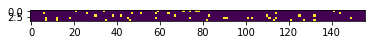

In [28]:
#Generar aleatoriamente entrada inicial

w = np.random.choice([0, 1], size=(tiempos_previos,156),  p=[0.95,0.05])
plt.imshow(w)

In [29]:
#Generar nueva cancion

tamano_cancion=200         #Numero de tiempos que tendra la cancion generada

u = np.zeros((1, tiempos_previos, 156), dtype=np.int32)
tamano_cancion=tamano_cancion+tiempos_previos
cancion_base=w
ent=np.zeros((tamano_cancion,156))
ent[0:tiempos_previos,:]=cancion_base
for i in tqdm(range (0,tamano_cancion-tiempos_previos)):			#Creacion de la cancion
    nueva_fila = model.predict(dimensionar(ent[i:i+tiempos_previos,:]), batch_size=1, verbose=1)
    if (np.all(np.round_(nueva_fila)==0)):
        nueva_fila[0,np.argsort(-nueva_fila)[0,:4]]=1
    ent[i+tiempos_previos] = nueva_fila
    ent=np.round_(ent)

ent=ent[tiempos_previos:tamano_cancion+tiempos_previos,:]

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

1/1 [==============================] - 0s


  0%|▍                                                                                 | 1/200 [00:00<00:47,  4.19it/s]

1/1 [==============================] - 0s


  2%|██                                                                                | 5/200 [00:00<00:34,  5.63it/s]

1/1 [==============================] - 0s


  4%|███▋                                                                              | 9/200 [00:00<00:25,  7.52it/s]

1/1 [==============================] - 0s


  6%|█████▎                                                                           | 13/200 [00:00<00:18,  9.90it/s]

1/1 [==============================] - 0s


  8%|██████▉                                                                          | 17/200 [00:00<00:14, 12.53it/s]

1/1 [==============================] - 0s


 10%|████████▌                                                                        | 21/200 [00:00<00:11, 15.51it/s]

1/1 [==============================] - 0s


 12%|█████████▋                                                                       | 24/200 [00:00<00:09, 18.07it/s]

1/1 [==============================] - 0s


 14%|███████████▎                                                                     | 28/200 [00:01<00:08, 21.11it/s]

1/1 [==============================] - 0s


 16%|████████████▉                                                                    | 32/200 [00:01<00:07, 23.42it/s]

1/1 [==============================] - 0s


 18%|██████████████▌                                                                  | 36/200 [00:01<00:06, 25.66it/s]

1/1 [==============================] - 0s


 20%|████████████████▏                                                                | 40/200 [00:01<00:05, 26.95it/s]

1/1 [==============================] - 0s


 22%|█████████████████▊                                                               | 44/200 [00:01<00:05, 29.87it/s]

1/1 [==============================] - 0s


 24%|███████████████████▍                                                             | 48/200 [00:01<00:04, 30.75it/s]

1/1 [==============================] - 0s


 26%|█████████████████████                                                            | 52/200 [00:01<00:04, 31.78it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▋                                                          | 56/200 [00:01<00:04, 33.02it/s]

1/1 [==============================] - 0s


 30%|████████████████████████▎                                                        | 60/200 [00:01<00:04, 33.19it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▉                                                       | 64/200 [00:02<00:03, 34.70it/s]

1/1 [==============================] - 0s


 34%|███████████████████████████▌                                                     | 68/200 [00:02<00:03, 35.55it/s]

1/1 [==============================] - 0s


 36%|█████████████████████████████▏                                                   | 72/200 [00:02<00:03, 35.56it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████▊                                                  | 76/200 [00:02<00:03, 34.41it/s]

1/1 [==============================] - 0s


 40%|████████████████████████████████▍                                                | 80/200 [00:02<00:03, 33.90it/s]

1/1 [==============================] - 0s


 42%|██████████████████████████████████                                               | 84/200 [00:02<00:03, 34.59it/s]

1/1 [==============================] - 0s


 44%|███████████████████████████████████▋                                             | 88/200 [00:02<00:03, 33.51it/s]

1/1 [==============================] - 0s


 46%|█████████████████████████████████████▎                                           | 92/200 [00:02<00:03, 33.20it/s]

1/1 [==============================] - 0s


 48%|██████████████████████████████████████▉                                          | 96/200 [00:03<00:03, 34.08it/s]

1/1 [==============================] - 0s


 50%|████████████████████████████████████████                                        | 100/200 [00:03<00:03, 32.29it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:03<00:02, 33.57it/s]

1/1 [==============================] - 0s


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:03<00:02, 34.42it/s]

1/1 [==============================] - 0s


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:03<00:02, 35.01it/s]

1/1 [==============================] - 0s


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:03<00:02, 34.04it/s]

1/1 [==============================] - 0s


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:03<00:02, 33.31it/s]

1/1 [==============================] - 0s


 62%|██████████████████████████████████████████████████                              | 125/200 [00:03<00:02, 33.39it/s]

1/1 [==============================] - 0s


 64%|███████████████████████████████████████████████████▌                            | 129/200 [00:04<00:02, 33.20it/s]

1/1 [==============================] - 0s


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:04<00:01, 33.65it/s]

1/1 [==============================] - 0s


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:04<00:01, 34.96it/s]

1/1 [==============================] - 0s


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:04<00:01, 35.61it/s]

1/1 [==============================] - 0s


 72%|██████████████████████████████████████████████████████████                      | 145/200 [00:04<00:01, 36.52it/s]

1/1 [==============================] - 0s


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [00:04<00:01, 34.66it/s]

1/1 [==============================] - 0s


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [00:04<00:01, 33.14it/s]

1/1 [==============================] - 0s


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [00:04<00:01, 34.66it/s]

1/1 [==============================] - 0s


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:04<00:01, 33.72it/s]

1/1 [==============================] - 0s


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [00:05<00:01, 33.60it/s]

1/1 [==============================] - 0s


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [00:05<00:00, 32.45it/s]

1/1 [==============================] - 0s


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [00:05<00:00, 31.77it/s]

1/1 [==============================] - 0s


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [00:05<00:00, 33.41it/s]

1/1 [==============================] - 0s


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:05<00:00, 34.68it/s]

1/1 [==============================] - 0s


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [00:05<00:00, 34.52it/s]

1/1 [==============================] - 0s


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [00:05<00:00, 33.80it/s]

1/1 [==============================] - 0s


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [00:05<00:00, 34.09it/s]

1/1 [==============================] - 0s


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [00:05<00:00, 35.57it/s]

1/1 [==============================] - 0s


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 32.90it/s]


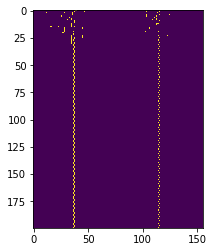

In [30]:
plt.imshow(ent)

In [31]:
#Guardar archivo midi

manipulacion_midi.noteStateMatrixToMidi(ent, "./cancion_generada5")